In [1]:
!nvidia-smi

Sat Jun  7 04:27:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P0             27W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Cài đặt các thư viện cần thiết
!pip install ultralytics roboflow pytesseract opencv-python-headless easyocr

# Cài đặt Tesseract OCR
!apt-get update -qq
!apt-get install -y tesseract-ocr -qq

import ultralytics
ultralytics.checks()

from ultralytics import YOLO
import os
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt
from roboflow import Roboflow
import easyocr

# Hàm hiển thị ảnh (thay cho cv2.imshow)
def show_image(image, title="Image"):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 6))
    plt.imshow(image_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

Ultralytics 8.3.151 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6362.2/8062.4 GB disk)


In [3]:
# Tải dataset từ Roboflow
def download_datasets():
    try:
        rf = Roboflow(api_key="b1CmorT7gd3GwVuBjzKl")  # Thay bằng API key của bạn
        
        # Tải Vehicle Registration Plates Dataset (giữ nguyên)
        project2 = rf.workspace("augmented-startups").project("vehicle-registration-plates-trudk")
        dataset2 = project2.version(1).download("yolov8")
        print(f"Tải Vehicle Registration Plates Dataset vào {dataset2.location}")
        
        # Tải License Plate Number Dataset (THAY ĐỔI)
        project3 = rf.workspace("project-enduni").project("license-plate-number-uqwhx")
        dataset3 = project3.version(2).download("yolov8")  # Version 2
        print(f"Tải License Plate Number Dataset vào {dataset3.location}")
        
        return dataset2.location, dataset3.location
    except Exception as e:
        print(f"Lỗi khi tải dataset: {e}")
        return None, None

# Chạy hàm tải dataset
dataset2_path, dataset3_path = download_datasets()

# Kiểm tra thư mục
print("Thư mục hiện tại:")
!ls /kaggle/working/

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Vehicle-Registration-Plates-1 in yolov8:: 100%|██████████| 17658/17658 [00:01<00:00, 9436.28it/s] 


Tải Vehicle Registration Plates Dataset vào /kaggle/working/Vehicle-Registration-Plates-1
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to License-Plate-Number-2 in yolov8:: 100%|██████████| 12400/12400 [00:01<00:00, 11788.62it/s]

Tải License Plate Number Dataset vào /kaggle/working/License-Plate-Number-2
Thư mục hiện tại:
License-Plate-Number-2	Vehicle-Registration-Plates-1


In [4]:
# Huấn luyện mô hình YOLOv8n
def train_yolo_model(data_path):
    try:
        model = YOLO("yolov8n.pt")  # Tải mô hình YOLOv8n
        
        # Huấn luyện mô hình
        results = model.train(
            data=f"{data_path}/data.yaml",
            epochs=20,
            imgsz=640,
            batch=16,
            name='license_plate_detection',
            device=0  # Sử dụng GPU
        )
        print("Huấn luyện hoàn tất!")
        return model, results
    except Exception as e:
        print(f"Lỗi khi huấn luyện mô hình: {e}")
        return None, None

# Chạy huấn luyện cho phát hiện biển số
if dataset2_path:
    plate_detection_model, train_results = train_yolo_model(dataset2_path)
else:
    print("Không thể huấn luyện do lỗi tải dataset")

100%|██████████| 6.25M/6.25M [00:00<00:00, 110MB/s]

Ultralytics 8.3.151 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/Vehicle-Registration-Plates-1/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=license_plate_detection, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=1

100%|██████████| 755k/755k [00:00<00:00, 29.7MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 108MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 791.0±607.9 MB/s, size: 27.2 KB)


train: Scanning /kaggle/working/Vehicle-Registration-Plates-1/train/labels... 6176 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6176/6176 [00:04<00:00, 1499.24it/s]


train: New cache created: /kaggle/working/Vehicle-Registration-Plates-1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 329.5±129.5 MB/s, size: 16.1 KB)


val: Scanning /kaggle/working/Vehicle-Registration-Plates-1/valid/labels... 1765 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1765/1765 [00:01<00:00, 1069.57it/s]

val: New cache created: /kaggle/working/Vehicle-Registration-Plates-1/valid/labels.cache


Plotting labels to runs/detect/license_plate_detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/license_plate_detection
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.16G      1.239      1.441      1.117         38        640: 100%|██████████| 386/386 [01:14<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:09<00:00,  5.63it/s]


                   all       1765       1840      0.955      0.924      0.946      0.595

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.44G      1.239     0.7998      1.113         39        640: 100%|██████████| 386/386 [01:11<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:08<00:00,  6.48it/s]

                   all       1765       1840      0.956      0.896      0.945      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.45G      1.222     0.6974      1.109         30        640: 100%|██████████| 386/386 [01:10<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:08<00:00,  6.63it/s]

                   all       1765       1840      0.955      0.913      0.951      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.46G      1.205     0.6641      1.102         26        640: 100%|██████████| 386/386 [01:10<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:08<00:00,  6.50it/s]

                   all       1765       1840       0.97      0.928      0.963      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.48G      1.176      0.627      1.087         39        640: 100%|██████████| 386/386 [01:09<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:08<00:00,  6.71it/s]

                   all       1765       1840       0.97      0.946      0.966      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       2.5G      1.165     0.5991      1.078         26        640: 100%|██████████| 386/386 [01:10<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:08<00:00,  6.60it/s]

                   all       1765       1840      0.979       0.94      0.976      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.51G      1.145     0.5812      1.073         20        640: 100%|██████████| 386/386 [01:10<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:08<00:00,  6.64it/s]

                   all       1765       1840      0.972      0.941      0.972      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.53G       1.14     0.5629      1.064         37        640: 100%|██████████| 386/386 [01:10<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:08<00:00,  6.78it/s]

                   all       1765       1840      0.971      0.945      0.974      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.55G      1.129     0.5486       1.06         24        640: 100%|██████████| 386/386 [01:10<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:08<00:00,  6.66it/s]

                   all       1765       1840      0.985      0.946      0.978      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.56G      1.123     0.5335      1.058         36        640: 100%|██████████| 386/386 [01:10<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:08<00:00,  6.74it/s]

                   all       1765       1840      0.986      0.944      0.976      0.683


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.58G      1.106     0.5036      1.078         16        640: 100%|██████████| 386/386 [01:10<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:08<00:00,  6.62it/s]

                   all       1765       1840       0.98      0.954      0.978      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       2.6G       1.09     0.4883      1.067         16        640: 100%|██████████| 386/386 [01:09<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:08<00:00,  6.68it/s]

                   all       1765       1840      0.977      0.952      0.977      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.62G      1.082     0.4808      1.064         17        640: 100%|██████████| 386/386 [01:09<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:08<00:00,  6.61it/s]

                   all       1765       1840      0.985      0.949      0.979      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.63G      1.074     0.4628      1.055         16        640: 100%|██████████| 386/386 [01:09<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:08<00:00,  6.67it/s]

                   all       1765       1840      0.985      0.948       0.98      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.65G      1.068     0.4513      1.055         16        640: 100%|██████████| 386/386 [01:09<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:08<00:00,  6.73it/s]

                   all       1765       1840      0.987      0.952      0.983      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.67G      1.053     0.4379      1.048         17        640: 100%|██████████| 386/386 [01:09<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:08<00:00,  6.51it/s]

                   all       1765       1840       0.99       0.95      0.984      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.69G      1.045     0.4256      1.037         16        640: 100%|██████████| 386/386 [01:09<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:08<00:00,  6.75it/s]

                   all       1765       1840      0.977      0.963      0.984      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20       2.7G      1.029     0.4148      1.037         16        640: 100%|██████████| 386/386 [01:09<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:08<00:00,  6.60it/s]


                   all       1765       1840      0.986      0.954      0.983      0.705

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.72G      1.019     0.3993       1.03         19        640: 100%|██████████| 386/386 [01:09<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:08<00:00,  6.75it/s]

                   all       1765       1840      0.986      0.953      0.985      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.74G      1.009     0.3886      1.023         17        640: 100%|██████████| 386/386 [01:09<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:08<00:00,  6.56it/s]


                   all       1765       1840      0.985      0.958      0.986       0.72

20 epochs completed in 0.440 hours.
Optimizer stripped from runs/detect/license_plate_detection/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/license_plate_detection/weights/best.pt, 6.2MB

Validating runs/detect/license_plate_detection/weights/best.pt...
Ultralytics 8.3.151 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:09<00:00,  5.79it/s]
invalid value encountered in less
invalid value encountered in less


                   all       1765       1840      0.985      0.958      0.986      0.719
Speed: 0.1ms preprocess, 1.4ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/license_plate_detection
Huấn luyện hoàn tất!


In [5]:
# CELL 5: Đánh giá mô hình phát hiện biển số (giữ nguyên)
# Kiểm tra validation và test
def evaluate_model(model, data_path):
    try:
        # Đánh giá trên tập validation
        val_results = model.val(data=f"{data_path}/data.yaml", split="val")
        print("Kết quả validation:")
        print(f"mAP50: {val_results.box.map50:.3f}, mAP50-95: {val_results.box.map:.3f}")
        
        # Đánh giá trên tập test
        test_results = model.val(data=f"{data_path}/data.yaml", split="test")
        print("Kết quả test:")
        print(f"mAP50: {test_results.box.map50:.3f}, mAP50-95: {test_results.box.map:.3f}")
        
        return val_results, test_results
    except Exception as e:
        print(f"Lỗi khi đánh giá mô hình: {e}")
        return None, None

# Chạy đánh giá
if plate_detection_model:
    val_results, test_results = evaluate_model(plate_detection_model, dataset2_path)
else:
    print("Không thể đánh giá do lỗi huấn luyện mô hình")

Ultralytics 8.3.151 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 908.6±848.2 MB/s, size: 44.4 KB)


val: Scanning /kaggle/working/Vehicle-Registration-Plates-1/valid/labels.cache... 1765 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1765/1765 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:10<00:00, 11.01it/s]
invalid value encountered in less
invalid value encountered in less


                   all       1765       1840      0.983      0.958      0.986      0.721
Speed: 0.2ms preprocess, 1.8ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/license_plate_detection2
Kết quả validation:
mAP50: 0.986, mAP50-95: 0.721
Ultralytics 8.3.151 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 598.4±228.1 MB/s, size: 20.4 KB)


val: Scanning /kaggle/working/Vehicle-Registration-Plates-1/test/labels... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<00:00, 1450.12it/s]

val: New cache created: /kaggle/working/Vehicle-Registration-Plates-1/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:05<00:00,  9.74it/s]
invalid value encountered in less
invalid value encountered in less


                   all        882        902       0.99      0.968      0.989      0.731
Speed: 0.3ms preprocess, 1.6ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/license_plate_detection3
Kết quả test:
mAP50: 0.989, mAP50-95: 0.731


In [6]:
def train_character_recognition_model(data_path):
    try:
        model = YOLO("yolov8n.pt")  # Tải mô hình YOLOv8n mới
        
        # Huấn luyện mô hình cho nhận dạng ký tự
        results = model.train(
            data=f"{data_path}/data.yaml",
            epochs=50,  # Tăng epochs cho nhận dạng ký tự
            imgsz=640,
            batch=16,
            name='character_recognition',
            device=0  # Sử dụng GPU
        )
        print("Huấn luyện mô hình nhận dạng ký tự hoàn tất!")
        return model, results
    except Exception as e:
        print(f"Lỗi khi huấn luyện mô hình nhận dạng ký tự: {e}")
        return None, None

# Chạy huấn luyện cho nhận dạng ký tự
if dataset3_path:
    character_model, char_train_results = train_character_recognition_model(dataset3_path)
else:
    print("Không thể huấn luyện mô hình nhận dạng ký tự do lỗi tải dataset")

Ultralytics 8.3.151 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/License-Plate-Number-2/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=character_recognition, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, persp

train: Scanning /kaggle/working/License-Plate-Number-2/train/labels... 4750 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4750/4750 [00:03<00:00, 1401.77it/s]


train: New cache created: /kaggle/working/License-Plate-Number-2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 77.7±25.5 MB/s, size: 3.4 KB)


val: Scanning /kaggle/working/License-Plate-Number-2/valid/labels... 707 images, 0 backgrounds, 0 corrupt: 100%|██████████| 707/707 [00:01<00:00, 694.15it/s]

val: New cache created: /kaggle/working/License-Plate-Number-2/valid/labels.cache


Plotting labels to runs/detect/character_recognition/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000294, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/character_recognition
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.51G      1.283      3.093       1.27        181        640: 100%|██████████| 297/297 [00:59<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.06it/s]


                   all        707       5736       0.84      0.327      0.363      0.253

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.75G      1.126      1.343      1.183        198        640: 100%|██████████| 297/297 [00:56<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.12it/s]

                   all        707       5736      0.731      0.749       0.76      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.75G      1.094      1.043      1.157        187        640: 100%|██████████| 297/297 [00:56<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.33it/s]

                   all        707       5736      0.847      0.851      0.917      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.75G      1.072     0.9276      1.142        209        640: 100%|██████████| 297/297 [00:55<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.06it/s]

                   all        707       5736      0.936      0.872      0.947      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.75G      1.058     0.8566      1.129        167        640: 100%|██████████| 297/297 [00:55<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.24it/s]

                   all        707       5736      0.923      0.918      0.958      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.75G      1.052     0.8158      1.128        159        640: 100%|██████████| 297/297 [00:55<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.41it/s]

                   all        707       5736       0.92      0.924      0.966      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.75G      1.039     0.7804      1.118        230        640: 100%|██████████| 297/297 [00:55<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.47it/s]

                   all        707       5736      0.936      0.933      0.968      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.75G      1.034     0.7505      1.115        229        640: 100%|██████████| 297/297 [00:55<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.46it/s]

                   all        707       5736      0.955      0.949      0.975       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.75G      1.025      0.719       1.11        194        640: 100%|██████████| 297/297 [00:55<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.51it/s]

                   all        707       5736      0.935      0.943      0.971      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.75G      1.023     0.7073      1.113        211        640: 100%|██████████| 297/297 [00:55<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.38it/s]

                   all        707       5736      0.953      0.945      0.975      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.75G      1.019     0.6885      1.112        142        640: 100%|██████████| 297/297 [00:55<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.41it/s]

                   all        707       5736      0.954      0.955      0.973      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.76G       1.02     0.6768      1.116        182        640: 100%|██████████| 297/297 [00:55<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.22it/s]

                   all        707       5736      0.952      0.954      0.972      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.77G      1.013     0.6607       1.11        188        640: 100%|██████████| 297/297 [00:55<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.45it/s]

                   all        707       5736      0.961      0.951      0.977      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.79G      1.007     0.6543      1.106        210        640: 100%|██████████| 297/297 [00:55<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.55it/s]

                   all        707       5736      0.959      0.948      0.977      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.81G      1.004     0.6414      1.107        227        640: 100%|██████████| 297/297 [00:55<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.51it/s]

                   all        707       5736      0.961      0.946      0.975      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.82G      1.004     0.6285      1.102        164        640: 100%|██████████| 297/297 [00:55<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.37it/s]

                   all        707       5736      0.969       0.95      0.976       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.84G      1.002     0.6195      1.104        223        640: 100%|██████████| 297/297 [00:55<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.48it/s]

                   all        707       5736      0.967      0.963      0.981      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.86G      1.001     0.6156      1.105        150        640: 100%|██████████| 297/297 [00:55<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.57it/s]

                   all        707       5736      0.954      0.944      0.976      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.87G     0.9935     0.6074      1.102        203        640: 100%|██████████| 297/297 [00:55<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.25it/s]

                   all        707       5736      0.958       0.94      0.976      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.89G     0.9947      0.598      1.105        177        640: 100%|██████████| 297/297 [00:55<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.56it/s]

                   all        707       5736      0.968      0.957      0.976      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.91G      0.992     0.5851        1.1        227        640: 100%|██████████| 297/297 [00:55<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.39it/s]

                   all        707       5736      0.956      0.951       0.98       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.93G     0.9924     0.5897      1.099        192        640: 100%|██████████| 297/297 [00:55<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.48it/s]

                   all        707       5736      0.969      0.952      0.977      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.94G     0.9881     0.5787      1.103        203        640: 100%|██████████| 297/297 [00:55<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.49it/s]

                   all        707       5736      0.966      0.967      0.979       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.96G     0.9754     0.5715      1.095        168        640: 100%|██████████| 297/297 [00:55<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.54it/s]

                   all        707       5736      0.964      0.952      0.982      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.98G     0.9844     0.5741        1.1        193        640: 100%|██████████| 297/297 [00:55<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.38it/s]

                   all        707       5736      0.974      0.953      0.977      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.99G      0.972     0.5639      1.094        167        640: 100%|██████████| 297/297 [00:55<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.16it/s]

                   all        707       5736      0.967      0.952      0.978      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.01G      0.973     0.5611      1.093        229        640: 100%|██████████| 297/297 [00:55<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.46it/s]

                   all        707       5736      0.966      0.952      0.978      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.03G     0.9703     0.5554      1.093        202        640: 100%|██████████| 297/297 [00:55<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.54it/s]

                   all        707       5736      0.964      0.956       0.98      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.04G     0.9665     0.5466       1.09        198        640: 100%|██████████| 297/297 [00:55<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.50it/s]

                   all        707       5736       0.96      0.954      0.979      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.06G     0.9649     0.5455      1.094        165        640: 100%|██████████| 297/297 [00:55<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.49it/s]

                   all        707       5736      0.966      0.961       0.98      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.08G     0.9612     0.5403      1.088        258        640: 100%|██████████| 297/297 [00:55<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.31it/s]

                   all        707       5736      0.968      0.954      0.982      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       3.1G     0.9606     0.5415       1.09        188        640: 100%|██████████| 297/297 [00:55<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.56it/s]

                   all        707       5736      0.965      0.957      0.981      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.11G     0.9593     0.5343       1.09        210        640: 100%|██████████| 297/297 [00:55<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.39it/s]

                   all        707       5736      0.963      0.951       0.98      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.13G     0.9539     0.5328      1.088        227        640: 100%|██████████| 297/297 [00:54<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.54it/s]

                   all        707       5736      0.969      0.952       0.98      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.15G     0.9517     0.5305      1.088        212        640: 100%|██████████| 297/297 [00:55<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.59it/s]

                   all        707       5736      0.975      0.951      0.979      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.16G     0.9508     0.5265      1.087        189        640: 100%|██████████| 297/297 [00:54<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.53it/s]

                   all        707       5736      0.975      0.956       0.98      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.18G     0.9497     0.5202      1.084        216        640: 100%|██████████| 297/297 [00:55<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.62it/s]

                   all        707       5736      0.972      0.952      0.979      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       3.2G     0.9434     0.5242      1.083        163        640: 100%|██████████| 297/297 [00:54<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.56it/s]

                   all        707       5736      0.971      0.964       0.98      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.21G     0.9423     0.5177      1.081        178        640: 100%|██████████| 297/297 [00:55<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.20it/s]

                   all        707       5736       0.97       0.96      0.978       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.23G     0.9388     0.5117      1.083        224        640: 100%|██████████| 297/297 [00:55<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.56it/s]

                   all        707       5736      0.972       0.96      0.979      0.736


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.25G        0.9     0.3915      1.127        113        640: 100%|██████████| 297/297 [00:55<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.42it/s]

                   all        707       5736      0.974      0.955      0.977      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.27G     0.8925     0.3825      1.118        112        640: 100%|██████████| 297/297 [00:54<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.48it/s]

                   all        707       5736      0.962      0.962      0.978      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.29G     0.8841     0.3787      1.115        110        640: 100%|██████████| 297/297 [00:54<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.52it/s]

                   all        707       5736      0.968      0.956      0.979      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       3.3G     0.8833     0.3759      1.115        113        640: 100%|██████████| 297/297 [00:54<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.45it/s]

                   all        707       5736      0.971      0.958      0.978      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.32G     0.8816     0.3731      1.117        109        640: 100%|██████████| 297/297 [00:54<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.53it/s]

                   all        707       5736      0.972      0.956      0.977      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.34G     0.8755     0.3697      1.114        112        640: 100%|██████████| 297/297 [00:54<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.55it/s]

                   all        707       5736      0.966      0.961      0.978      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.35G     0.8712     0.3659       1.11        114        640: 100%|██████████| 297/297 [00:54<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.35it/s]

                   all        707       5736      0.965      0.961      0.977       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.37G     0.8681     0.3654      1.112        110        640: 100%|██████████| 297/297 [00:54<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.54it/s]

                   all        707       5736      0.963      0.957      0.978      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.39G     0.8654     0.3636      1.105        106        640: 100%|██████████| 297/297 [00:54<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.53it/s]

                   all        707       5736      0.965      0.959      0.979      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       3.4G     0.8626     0.3612      1.104        110        640: 100%|██████████| 297/297 [00:54<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  5.56it/s]

                   all        707       5736      0.966       0.96      0.979      0.731



50 epochs completed in 0.832 hours.
Optimizer stripped from runs/detect/character_recognition/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/character_recognition/weights/best.pt, 6.3MB

Validating runs/detect/character_recognition/weights/best.pt...
Ultralytics 8.3.151 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,011,498 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.79it/s]
invalid value encountered in less
invalid value encountered in less


                   all        707       5736      0.971      0.961      0.979      0.735
                     0        325        406      0.985       0.98      0.993       0.76
                     1        493        771      0.991      0.952      0.983      0.639
                     2        369        486      0.994      0.986      0.994      0.758
                     3        293        375      0.997      0.971      0.995       0.76
                     4        307        395       0.99      0.989      0.991      0.721
                     5        495        719      0.989      0.989      0.992      0.768
                     6        298        393      0.985      0.987      0.988       0.76
                     7        294        391      0.972      0.987      0.988      0.739
                     8        269        354       0.98      0.972      0.985      0.734
                     9        420        567      0.995      0.979      0.993      0.755
                     

In [19]:
def train_character_recognition_model_v8s(data_path):
    try:
        model = YOLO("yolov8s.pt")  # Tải mô hình YOLOv8s (lớn hơn v8n)
        
        # Huấn luyện mô hình YOLOv8s cho nhận dạng ký tự
        results = model.train(
            data=f"{data_path}/data.yaml",
            epochs=50,  # Tăng epochs cho nhận dạng ký tự
            imgsz=640,
            batch=16,
            name='character_recognition_v8s',  # Tên khác để phân biệt
            device=0  # Sử dụng GPU
        )
        
        print("Huấn luyện mô hình YOLOv8s nhận dạng ký tự hoàn tất!")
        return model, results
        
    except Exception as e:
        print(f"Lỗi khi huấn luyện mô hình YOLOv8s nhận dạng ký tự: {e}")
        return None, None

# Chạy huấn luyện cho nhận dạng ký tự với YOLOv8s
if dataset3_path:
    character_model_v8s, char_train_results_v8s = train_character_recognition_model_v8s(dataset3_path)
else:
    print("Không thể huấn luyện mô hình YOLOv8s nhận dạng ký tự do lỗi tải dataset")

100%|██████████| 21.5M/21.5M [00:00<00:00, 195MB/s]


Ultralytics 8.3.151 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/License-Plate-Number-2/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=character_recognition_v8s, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, p

train: Scanning /kaggle/working/License-Plate-Number-2/train/labels.cache... 4750 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4750/4750 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 50.9±46.1 MB/s, size: 3.4 KB)


val: Scanning /kaggle/working/License-Plate-Number-2/valid/labels.cache... 707 images, 0 backgrounds, 0 corrupt: 100%|██████████| 707/707 [00:00<?, ?it/s]


Plotting labels to runs/detect/character_recognition_v8s/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000294, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/character_recognition_v8s
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.93G      1.274      1.955      1.276        181        640: 100%|██████████| 297/297 [01:32<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  3.94it/s]


                   all        707       5736      0.856      0.806      0.878      0.624

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.93G      1.084     0.8407      1.141        198        640: 100%|██████████| 297/297 [01:30<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.11it/s]

                   all        707       5736      0.889      0.876      0.935      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.93G      1.068     0.7359      1.143        187        640: 100%|██████████| 297/297 [01:30<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.15it/s]

                   all        707       5736       0.94      0.938      0.964      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.93G      1.055     0.6768      1.146        209        640: 100%|██████████| 297/297 [01:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.16it/s]

                   all        707       5736      0.887       0.91      0.946      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.93G      1.043     0.6356      1.139        167        640: 100%|██████████| 297/297 [01:30<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.15it/s]

                   all        707       5736      0.938      0.948      0.972       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.93G      1.036     0.6101      1.144        159        640: 100%|██████████| 297/297 [01:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.19it/s]

                   all        707       5736      0.953      0.937      0.972      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.93G      1.025     0.5916      1.138        230        640: 100%|██████████| 297/297 [01:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.19it/s]

                   all        707       5736      0.958      0.949      0.973      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.93G      1.019     0.5728      1.135        229        640: 100%|██████████| 297/297 [01:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.18it/s]

                   all        707       5736      0.964       0.94      0.978      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.93G      1.009     0.5557      1.132        194        640: 100%|██████████| 297/297 [01:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.17it/s]

                   all        707       5736      0.961      0.947      0.976      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.93G      1.007     0.5508      1.134        211        640: 100%|██████████| 297/297 [01:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.19it/s]

                   all        707       5736      0.956      0.951      0.977       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.93G      1.004      0.539      1.132        142        640: 100%|██████████| 297/297 [01:29<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.20it/s]

                   all        707       5736      0.967      0.959      0.977       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.93G      1.005     0.5394      1.136        182        640: 100%|██████████| 297/297 [01:30<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.19it/s]

                   all        707       5736      0.957      0.947      0.978      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.93G     0.9966     0.5264       1.13        188        640: 100%|██████████| 297/297 [01:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.21it/s]

                   all        707       5736       0.96      0.957      0.977      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.93G     0.9906     0.5263      1.129        210        640: 100%|██████████| 297/297 [01:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.20it/s]

                   all        707       5736      0.961      0.961      0.977      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.93G     0.9852     0.5182      1.128        227        640: 100%|██████████| 297/297 [01:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.20it/s]

                   all        707       5736      0.963      0.957      0.976      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.93G     0.9847     0.5093      1.126        164        640: 100%|██████████| 297/297 [01:29<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.21it/s]

                   all        707       5736      0.967      0.952      0.977      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.93G     0.9816     0.5042      1.126        223        640: 100%|██████████| 297/297 [01:29<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.18it/s]

                   all        707       5736      0.964      0.959      0.976      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.93G     0.9796     0.5039      1.129        150        640: 100%|██████████| 297/297 [01:29<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.17it/s]

                   all        707       5736      0.971      0.957       0.98      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.93G     0.9682      0.496      1.123        203        640: 100%|██████████| 297/297 [01:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.16it/s]

                   all        707       5736      0.957      0.962      0.983      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.93G     0.9697     0.4931      1.124        177        640: 100%|██████████| 297/297 [01:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.16it/s]

                   all        707       5736      0.969       0.96      0.976      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.93G     0.9643     0.4822      1.117        227        640: 100%|██████████| 297/297 [01:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.18it/s]

                   all        707       5736      0.965      0.961      0.977       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.93G     0.9684     0.4863      1.119        192        640: 100%|██████████| 297/297 [01:30<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.16it/s]

                   all        707       5736      0.967      0.951      0.977      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.93G     0.9579     0.4789       1.12        203        640: 100%|██████████| 297/297 [01:29<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.19it/s]

                   all        707       5736      0.959      0.948      0.976      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.93G     0.9439     0.4727      1.112        168        640: 100%|██████████| 297/297 [01:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.17it/s]

                   all        707       5736      0.958       0.96      0.978      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.93G     0.9528     0.4763      1.117        193        640: 100%|██████████| 297/297 [01:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.18it/s]

                   all        707       5736      0.965       0.96      0.978      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.93G     0.9391     0.4669      1.108        167        640: 100%|██████████| 297/297 [01:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.17it/s]

                   all        707       5736       0.96      0.966      0.975      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.93G     0.9353     0.4664      1.104        229        640: 100%|██████████| 297/297 [01:29<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.19it/s]

                   all        707       5736      0.969      0.957      0.979      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.93G     0.9321     0.4609      1.105        202        640: 100%|██████████| 297/297 [01:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.20it/s]

                   all        707       5736      0.972      0.962      0.979       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.93G     0.9246     0.4539      1.096        198        640: 100%|██████████| 297/297 [01:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.20it/s]

                   all        707       5736      0.959      0.963      0.978      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.93G     0.9242     0.4528      1.103        165        640: 100%|██████████| 297/297 [01:30<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.13it/s]

                   all        707       5736       0.96       0.96      0.974      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.93G     0.9181     0.4467      1.095        258        640: 100%|██████████| 297/297 [01:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.21it/s]

                   all        707       5736       0.96      0.963      0.978      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.93G     0.9122     0.4508      1.095        188        640: 100%|██████████| 297/297 [01:30<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.19it/s]

                   all        707       5736      0.972      0.959      0.979      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.93G     0.9082      0.442      1.091        210        640: 100%|██████████| 297/297 [01:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.17it/s]

                   all        707       5736      0.971      0.957      0.977      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.93G     0.8996     0.4402      1.087        227        640: 100%|██████████| 297/297 [01:29<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.16it/s]

                   all        707       5736      0.961       0.96      0.978      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.93G     0.8994     0.4392      1.089        212        640: 100%|██████████| 297/297 [01:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.17it/s]

                   all        707       5736      0.974      0.959      0.981      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.93G     0.8942     0.4342      1.086        189        640: 100%|██████████| 297/297 [01:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.18it/s]

                   all        707       5736      0.964      0.959      0.979      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.93G     0.8907     0.4301      1.081        216        640: 100%|██████████| 297/297 [01:30<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.15it/s]

                   all        707       5736      0.962      0.964      0.979      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.93G      0.881     0.4316      1.079        163        640: 100%|██████████| 297/297 [01:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.18it/s]

                   all        707       5736      0.967      0.958      0.976      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.93G     0.8774     0.4269      1.077        178        640: 100%|██████████| 297/297 [01:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.20it/s]

                   all        707       5736      0.964      0.962      0.978      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.93G     0.8699     0.4231      1.077        224        640: 100%|██████████| 297/297 [01:29<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.16it/s]

                   all        707       5736      0.969      0.954      0.975      0.726


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.93G     0.8223     0.3153      1.111        113        640: 100%|██████████| 297/297 [01:29<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.18it/s]

                   all        707       5736      0.955      0.963      0.975      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.93G      0.813     0.3098      1.101        112        640: 100%|██████████| 297/297 [01:29<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.16it/s]

                   all        707       5736      0.966      0.952      0.977      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.93G     0.8019      0.305      1.092        110        640: 100%|██████████| 297/297 [01:29<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.20it/s]

                   all        707       5736      0.962      0.962      0.976      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.93G     0.7939     0.3023      1.093        113        640: 100%|██████████| 297/297 [01:29<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.19it/s]

                   all        707       5736      0.966      0.959      0.977       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.93G     0.7894     0.2991      1.093        109        640: 100%|██████████| 297/297 [01:29<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.19it/s]

                   all        707       5736      0.965      0.961      0.979      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.93G     0.7806     0.2961      1.088        112        640: 100%|██████████| 297/297 [01:29<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.21it/s]

                   all        707       5736      0.965      0.964      0.976      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.93G     0.7732     0.2926       1.08        114        640: 100%|██████████| 297/297 [01:29<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.18it/s]

                   all        707       5736      0.971      0.953      0.976      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.93G     0.7676     0.2917       1.08        110        640: 100%|██████████| 297/297 [01:29<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.19it/s]

                   all        707       5736      0.968      0.956      0.975      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.93G     0.7614     0.2888      1.072        106        640: 100%|██████████| 297/297 [01:29<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.17it/s]

                   all        707       5736       0.97      0.951      0.975      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.93G      0.758     0.2876      1.069        110        640: 100%|██████████| 297/297 [01:29<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.19it/s]

                   all        707       5736      0.966      0.953      0.975      0.725



50 epochs completed in 1.333 hours.
Optimizer stripped from runs/detect/character_recognition_v8s/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/character_recognition_v8s/weights/best.pt, 22.5MB

Validating runs/detect/character_recognition_v8s/weights/best.pt...
Ultralytics 8.3.151 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 11,137,194 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:07<00:00,  3.04it/s]
invalid value encountered in less
invalid value encountered in less


                   all        707       5736      0.972      0.956       0.98      0.734
                     0        325        406       0.99      0.986       0.99      0.756
                     1        493        771      0.991      0.963      0.981      0.649
                     2        369        486      0.996      0.979      0.994      0.754
                     3        293        375      0.997      0.981      0.994      0.774
                     4        307        395      0.992      0.992       0.99      0.714
                     5        495        719      0.991      0.989      0.989      0.766
                     6        298        393      0.984      0.985      0.989      0.755
                     7        294        391      0.977      0.974      0.982       0.74
                     8        269        354      0.986      0.975       0.99       0.74
                     9        420        567      0.995       0.97      0.992       0.77
                     

In [7]:
if character_model:
    print("Đánh giá mô hình nhận dạng ký tự:")
    char_val_results, char_test_results = evaluate_model(character_model, dataset3_path)
else:
    print("Không thể đánh giá mô hình nhận dạng ký tự")

Đánh giá mô hình nhận dạng ký tự:
Ultralytics 8.3.151 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,011,498 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 150.6±41.5 MB/s, size: 3.5 KB)


val: Scanning /kaggle/working/License-Plate-Number-2/valid/labels.cache... 707 images, 0 backgrounds, 0 corrupt: 100%|██████████| 707/707 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:06<00:00,  6.53it/s]
invalid value encountered in less
invalid value encountered in less


                   all        707       5736      0.972      0.961      0.979      0.736
                     0        325        406      0.986       0.98      0.993       0.76
                     1        493        771      0.991      0.952      0.983      0.641
                     2        369        486      0.994      0.986      0.994       0.76
                     3        293        375      0.998      0.971      0.995      0.762
                     4        307        395       0.99      0.989      0.991      0.722
                     5        495        719      0.989      0.989      0.992      0.767
                     6        298        393      0.985      0.987      0.988      0.758
                     7        294        391      0.972      0.987      0.988       0.74
                     8        269        354       0.98      0.971      0.985      0.731
                     9        420        567      0.995      0.979      0.993      0.755
                     

val: Scanning /kaggle/working/License-Plate-Number-2/test/labels... 737 images, 0 backgrounds, 0 corrupt: 100%|██████████| 737/737 [00:00<00:00, 1399.09it/s]

val: /kaggle/working/License-Plate-Number-2/test/images/ndata148_jpg.rf.07f60134a1846ffca2d970335ef91520.jpg: 1 duplicate labels removed
val: /kaggle/working/License-Plate-Number-2/test/images/ndata301_jpg.rf.72bd23482ac1940123143e6c122204ed.jpg: 1 duplicate labels removed
val: New cache created: /kaggle/working/License-Plate-Number-2/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  6.91it/s]
invalid value encountered in less
invalid value encountered in less


                   all        737       6014      0.897      0.817      0.899      0.739
                     0        403        569      0.971      0.817      0.947      0.793
                     1        434        704       0.99      0.814      0.971      0.764
                     2        444        655      0.976      0.927      0.975      0.822
                     3        384        544      0.981      0.936      0.981      0.818
                     4        282        365      0.985      0.912       0.98      0.803
                     5        330        431      0.979      0.965      0.987      0.826
                     6        313        404      0.992      0.923      0.984      0.819
                     7        313        423      0.863      0.936      0.958      0.776
                     8        287        404      0.977      0.938      0.984      0.821
                     9        438        628       0.99      0.937      0.981      0.819
                     

In [21]:
if character_model_v8s:
    print("Đánh giá mô hình YOLOv8s nhận dạng ký tự:")
    char_val_results_v8s, char_test_results_v8s = evaluate_model(character_model_v8s, dataset3_path)
else:
    print("Không thể đánh giá mô hình YOLOv8s nhận dạng ký tự")

Đánh giá mô hình YOLOv8s nhận dạng ký tự:
Ultralytics 8.3.151 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 144.8±75.3 MB/s, size: 3.6 KB)


val: Scanning /kaggle/working/License-Plate-Number-2/valid/labels.cache... 707 images, 0 backgrounds, 0 corrupt: 100%|██████████| 707/707 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:08<00:00,  5.52it/s]
invalid value encountered in less
invalid value encountered in less


                   all        707       5736      0.971      0.957       0.98      0.734
                     0        325        406       0.99      0.987       0.99      0.759
                     1        493        771      0.991      0.963      0.981      0.649
                     2        369        486      0.998      0.981      0.994      0.754
                     3        293        375      0.997      0.981      0.994      0.774
                     4        307        395      0.991      0.992       0.99      0.714
                     5        495        719      0.991      0.989      0.989      0.765
                     6        298        393      0.984      0.985      0.988      0.754
                     7        294        391      0.976      0.974      0.982      0.739
                     8        269        354      0.986      0.975       0.99       0.74
                     9        420        567      0.995       0.97      0.992       0.77
                     

val: Scanning /kaggle/working/License-Plate-Number-2/test/labels.cache... 737 images, 0 backgrounds, 0 corrupt: 100%|██████████| 737/737 [00:00<?, ?it/s]

val: /kaggle/working/License-Plate-Number-2/test/images/ndata148_jpg.rf.07f60134a1846ffca2d970335ef91520.jpg: 1 duplicate labels removed
val: /kaggle/working/License-Plate-Number-2/test/images/ndata301_jpg.rf.72bd23482ac1940123143e6c122204ed.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.72it/s]
invalid value encountered in less
invalid value encountered in less


                   all        737       6014      0.913      0.832      0.919       0.74
                     0        403        569      0.974      0.867      0.965        0.8
                     1        434        704      0.973      0.865      0.968      0.746
                     2        444        655      0.985      0.907      0.977      0.806
                     3        384        544      0.989      0.914      0.984      0.816
                     4        282        365      0.986      0.932      0.977      0.798
                     5        330        431       0.98      0.956      0.987      0.821
                     6        313        404      0.985       0.95      0.983      0.827
                     7        313        423      0.944      0.917      0.973      0.786
                     8        287        404      0.984      0.934      0.984      0.814
                     9        438        628      0.991        0.9      0.975      0.815
                     

In [25]:
def compare_models_performance():
    print("\n" + "="*50)
    print("SO SÁNH KẾT QUẢ GIỮA YOLOv8n VÀ YOLOv8s")
    print("="*50)
    
    if character_model and character_model_v8s:
        print("\n--- YOLOv8n Character Recognition ---")
        if char_val_results:
            try:
                # Truy cập thuộc tính box.map50 và box.map
                map50 = getattr(char_val_results.box, 'map50', 'N/A')
                map = getattr(char_val_results.box, 'map', 'N/A')
                print(f"Validation mAP50: {map50}")
                print(f"Validation mAP50-95: {map}")
            except:
                print("Không thể truy cập metrics của YOLOv8n")
        
        if char_test_results:
            try:
                map50 = getattr(char_test_results.box, 'map50', 'N/A')
                map = getattr(char_test_results.box, 'map', 'N/A')
                print(f"Test mAP50: {map50}")
                print(f"Test mAP50-95: {map}")
            except:
                print("Không thể truy cập test metrics của YOLOv8n")
            
        print("\n--- YOLOv8s Character Recognition ---")
        if char_val_results_v8s:
            try:
                map50 = getattr(char_val_results_v8s.box, 'map50', 'N/A')
                map = getattr(char_val_results_v8s.box, 'map', 'N/A')
                print(f"Validation mAP50: {map50}")
                print(f"Validation mAP50-95: {map}")
            except:
                print("Không thể truy cập metrics của YOLOv8s")
        
        if char_test_results_v8s:
            try:
                map50 = getattr(char_test_results_v8s.box, 'map50', 'N/A')
                map = getattr(char_test_results_v8s.box, 'map', 'N/A')
                print(f"Test mAP50: {map50}")
                print(f"Test mAP50-95: {map}")
            except:
                print("Không thể truy cập test metrics của YOLOv8s")
            
        print("\n--- Kết luận ---")
        print("YOLOv8s thường có độ chính xác cao hơn YOLOv8n nhưng chậm hơn và nặng hơn")
        print("YOLOv8n nhanh hơn và nhẹ hơn, phù hợp cho inference real-time")
        
    else:
        print("Không thể so sánh do một trong hai mô hình chưa được train thành công")

# Chạy so sánh
compare_models_performance()


SO SÁNH KẾT QUẢ GIỮA YOLOv8n VÀ YOLOv8s

--- YOLOv8n Character Recognition ---
Validation mAP50: 0.9792611178233803
Validation mAP50-95: 0.7362258460625114
Test mAP50: 0.8993260260162903
Test mAP50-95: 0.7386084667904877

--- YOLOv8s Character Recognition ---
Validation mAP50: 0.9804753167359157
Validation mAP50-95: 0.7343348829113802
Test mAP50: 0.9192633828044422
Test mAP50-95: 0.7401297447253814

--- Kết luận ---
YOLOv8s thường có độ chính xác cao hơn YOLOv8n nhưng chậm hơn và nặng hơn
YOLOv8n nhanh hơn và nhẹ hơn, phù hợp cho inference real-time


In [26]:
def extract_license_plate_text(image_path, plate_model, char_model):
    """
    Hàm tổng hợp để phát hiện biển số và nhận dạng ký tự chỉ bằng YOLO
    """
    try:
        # Đọc ảnh
        image = cv2.imread(image_path)
        if image is None:
            print(f"Không thể đọc ảnh: {image_path}")
            return None
        
        # Bước 1: Phát hiện biển số
        plate_results = plate_model(image)
        
        extracted_texts = []
        
        for result in plate_results:
            boxes = result.boxes
            if boxes is not None:
                for box in boxes:
                    # Lấy tọa độ bounding box
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
                    
                    # Cắt vùng biển số
                    license_plate = image[y1:y2, x1:x2]
                    
                    if license_plate.size > 0:
                        # Sử dụng mô hình YOLO nhận dạng ký tự
                        char_results = char_model(license_plate)
                        yolo_text = ""
                        
                        # Sắp xếp các ký tự theo vị trí
                        char_detections = []
                        for char_result in char_results:
                            if char_result.boxes is not None:
                                for char_box in char_result.boxes:
                                    x_char = float(char_box.xyxy[0][0])  # Tọa độ x của ký tự
                                    class_id = int(char_box.cls[0])
                                    confidence = float(char_box.conf[0])
                                    
                                    # Lấy tên class từ model
                                    if hasattr(char_result, 'names') and class_id in char_result.names:
                                        char = char_result.names[class_id]
                                        char_detections.append((x_char, char, confidence))
                        
                        # Sắp xếp theo tọa độ x (từ trái sang phải) và ghép thành chuỗi
                        char_detections.sort(key=lambda x: x[0])
                        yolo_text = ''.join([char for _, char, _ in char_detections])
                        
                        # Tính confidence trung bình
                        avg_confidence = sum([conf for _, _, conf in char_detections]) / len(char_detections) if char_detections else 0.0
                        
                        # Kết quả
                        result_dict = {
                            'bbox': (x1, y1, x2, y2),
                            'text': yolo_text,
                            'confidence': avg_confidence,
                            'char_details': char_detections,
                            'license_plate_image': license_plate
                        }
                        
                        extracted_texts.append(result_dict)
        
        return extracted_texts
    
    except Exception as e:
        print(f"Lỗi trong quá trình xử lý: {e}")
        return None


Xử lý ảnh: CarLongPlate857_jpg.rf.5168a72840445692c41cf3f802cf0f71.jpg

--- Kết quả với YOLOv8n ---

0: 416x640 1 License_Plate, 12.4ms
Speed: 5.0ms preprocess, 12.4ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)

0: 192x640 1 1, 1 4, 1 5, 2 7s, 1 8, 1 9, 1 F, 9.8ms
Speed: 1.2ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 192, 640)
  Biển số 1:
    Text: 51F94877
    Confidence: 0.794
    Chi tiết ký tự: [(7.3826189041137695, '5', 0.7220112681388855), (19.068124771118164, '1', 0.7814946174621582), (28.499483108520508, 'F', 0.7825475931167603), (46.28120422363281, '9', 0.6243071556091309), (57.23655700683594, '4', 0.8432940244674683), (67.52157592773438, '8', 0.8600307106971741), (81.6089859008789, '7', 0.8854044675827026), (92.33213806152344, '7', 0.854623556137085)]


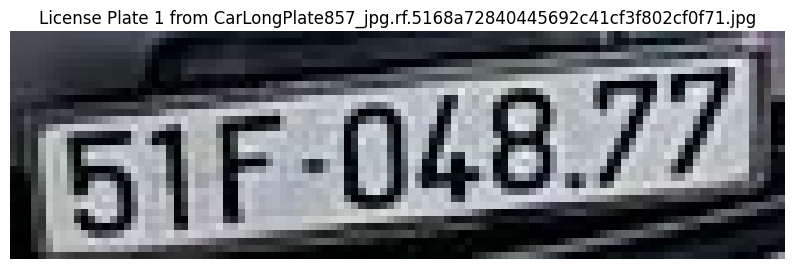


--- Kết quả với YOLOv8s ---

0: 416x640 1 License_Plate, 6.6ms
Speed: 2.9ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)

0: 192x640 1 0, 1 1, 1 4, 1 5, 2 7s, 1 8, 1 F, 33.2ms
Speed: 0.8ms preprocess, 33.2ms inference, 1.5ms postprocess per image at shape (1, 3, 192, 640)
  Biển số 1:
    Text: 51F04877
    Confidence: 0.818
    Chi tiết ký tự: [(7.186007976531982, '5', 0.7913618087768555), (19.08403205871582, '1', 0.8140672445297241), (28.76934814453125, 'F', 0.848289966583252), (46.24856185913086, '0', 0.620491087436676), (57.19336700439453, '4', 0.7650495171546936), (67.47351837158203, '8', 0.8742625713348389), (81.59647369384766, '7', 0.912696897983551), (92.25489807128906, '7', 0.9164921045303345)]

Xử lý ảnh: CarLongPlateGen2126_jpg.rf.c002be6f9bebc1ef9a23bf100410fba7.jpg

--- Kết quả với YOLOv8n ---

0: 416x640 1 License_Plate, 6.1ms
Speed: 2.1ms preprocess, 6.1ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)

0: 288x640 

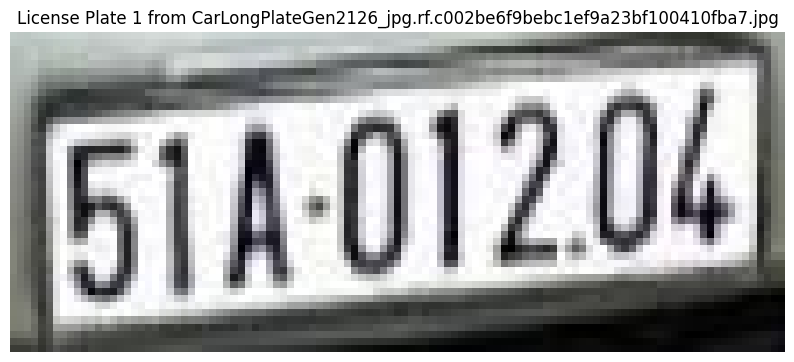


--- Kết quả với YOLOv8s ---

0: 416x640 1 License_Plate, 6.6ms
Speed: 2.3ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)

0: 288x640 2 0s, 2 1s, 1 2, 1 4, 1 5, 1 A, 35.1ms
Speed: 1.3ms preprocess, 35.1ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 640)
  Biển số 1:
    Text: 51A01204
    Confidence: 0.815
    Chi tiết ký tự: [(7.445400238037109, '5', 0.8671098351478577), (20.141874313354492, '1', 0.7785012125968933), (30.11131477355957, 'A', 0.8087373375892639), (46.07356262207031, '0', 0.8047170639038086), (58.595760345458984, '1', 0.700366735458374), (68.00695037841797, '2', 0.8422480821609497), (82.08015441894531, '0', 0.8771018981933594), (92.68012237548828, '4', 0.840971827507019)]

Xử lý ảnh: CarLongPlateGen3528_jpg.rf.2d80d2c0381325b70e40926fbd233111.jpg

--- Kết quả với YOLOv8n ---

0: 416x640 1 License_Plate, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)

0: 320x640 1

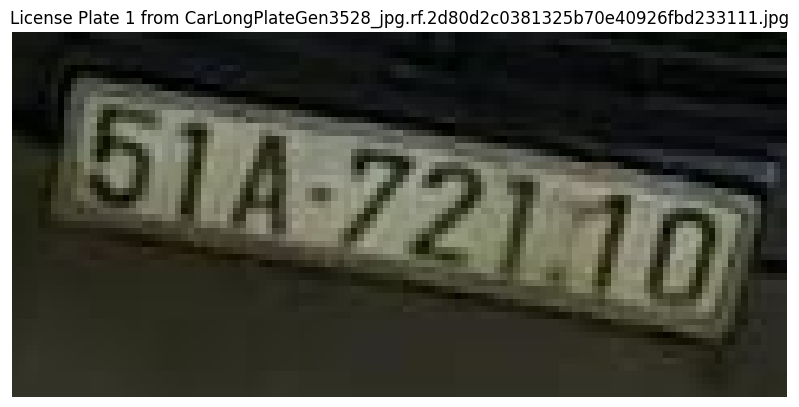


--- Kết quả với YOLOv8s ---

0: 416x640 1 License_Plate, 6.5ms
Speed: 2.4ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)

0: 320x640 1 1, 1 2, 1 5, 1 P, 34.8ms
Speed: 1.4ms preprocess, 34.8ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)
  Biển số 1:
    Text: 512P
    Confidence: 0.535
    Chi tiết ký tự: [(11.464324951171875, '5', 0.550990104675293), (24.102352142333984, '1', 0.7710554003715515), (61.214698791503906, '2', 0.49169617891311646), (96.00704956054688, 'P', 0.32755246758461)]

Xử lý ảnh: CarLongPlate636_jpg.rf.513ae01551171cc20ab684cfdcf8dd25.jpg

--- Kết quả với YOLOv8n ---

0: 416x640 1 License_Plate, 6.2ms
Speed: 1.7ms preprocess, 6.2ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)

0: 224x640 2 1s, 3 4s, 1 5, 1 6, 1 F, 8.4ms
Speed: 1.4ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 640)
  Biển số 1:
    Text: 51F44614
    Confidence: 0.798
    Chi tiết ký tự: [

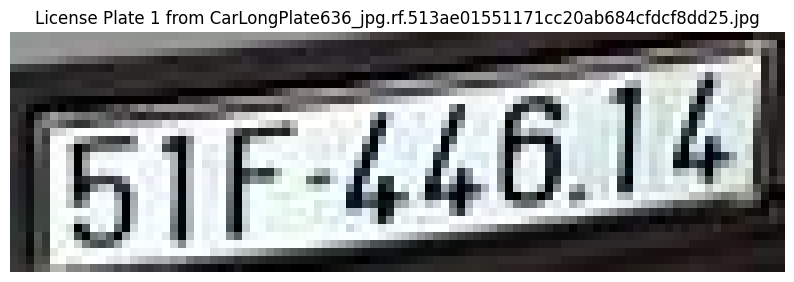


--- Kết quả với YOLOv8s ---

0: 416x640 1 License_Plate, 6.3ms
Speed: 1.7ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)

0: 224x640 2 1s, 3 4s, 1 5, 1 6, 1 F, 33.0ms
Speed: 1.0ms preprocess, 33.0ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 640)
  Biển số 1:
    Text: 51F44614
    Confidence: 0.813
    Chi tiết ký tự: [(6.872710704803467, '5', 0.8285185098648071), (17.903738021850586, '1', 0.7687479257583618), (26.2891788482666, 'F', 0.8218039870262146), (41.410972595214844, '4', 0.7937118411064148), (51.300743103027344, '4', 0.8111847043037415), (60.92185592651367, '6', 0.83953857421875), (74.088134765625, '1', 0.8196431398391724), (82.43096160888672, '4', 0.8192908763885498)]

Xử lý ảnh: CarLongPlateGen1533_jpg.rf.14083aa8d603c3e385abbebbc8107a61.jpg

--- Kết quả với YOLOv8n ---

0: 416x640 1 License_Plate, 6.1ms
Speed: 1.9ms preprocess, 6.1ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)

0: 224x640 1 0, 3 3

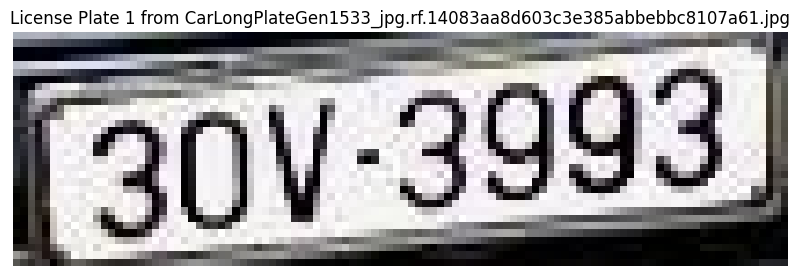


--- Kết quả với YOLOv8s ---

0: 416x640 1 License_Plate, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)

0: 224x640 1 0, 3 3s, 2 9s, 1 V, 1 Y, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 640)
  Biển số 1:
    Text: 30YV3993
    Confidence: 0.696
    Chi tiết ký tự: [(10.575599670410156, '3', 0.8271368145942688), (22.343578338623047, '0', 0.8294435739517212), (34.55520248413086, 'Y', 0.3303448259830475), (34.58676528930664, 'V', 0.25975412130355835), (52.36686325073242, '3', 0.7067471146583557), (64.20905303955078, '9', 0.8619126677513123), (75.4803466796875, '9', 0.8719112277030945), (87.43164825439453, '3', 0.8802769780158997)]


In [27]:
def test_yolo_ocr_system():
    """
    Test hệ thống OCR với cả hai mô hình YOLOv8n và YOLOv8s
    """
    if not plate_detection_model:
        print("Cần có mô hình phát hiện biển số để test!")
        return
    
    # Kiểm tra mô hình nào có sẵn
    models_to_test = []
    if character_model:
        models_to_test.append(("YOLOv8n", character_model))
    if character_model_v8s:
        models_to_test.append(("YOLOv8s", character_model_v8s))
    
    if not models_to_test:
        print("Cần có ít nhất một mô hình nhận dạng ký tự để test!")
        return
    
    # Lấy một số ảnh test từ dataset
    test_images_path = f"{dataset2_path}/test/images"
    
    if os.path.exists(test_images_path):
        test_images = os.listdir(test_images_path)[:5]  # Test 5 ảnh đầu tiên
        
        for img_name in test_images:
            img_path = os.path.join(test_images_path, img_name)
            print(f"\n{'='*60}")
            print(f"Xử lý ảnh: {img_name}")
            print('='*60)
            
            # Test với từng mô hình
            for model_name, char_model in models_to_test:
                print(f"\n--- Kết quả với {model_name} ---")
                results = extract_license_plate_text(img_path, plate_detection_model, char_model)
                
                if results:
                    for i, result in enumerate(results):
                        print(f"  Biển số {i+1}:")
                        print(f"    Text: {result['text']}")
                        print(f"    Confidence: {result['confidence']:.3f}")
                        print(f"    Chi tiết ký tự: {result['char_details']}")
                        
                        # Hiển thị ảnh biển số đã cắt (chỉ lần đầu tiên)
                        if model_name == models_to_test[0][0]:
                            show_image(result['license_plate_image'], f"License Plate {i+1} from {img_name}")
                else:
                    print("    Không phát hiện được biển số")
    else:
        print(f"Không tìm thấy thư mục test: {test_images_path}")

# Chạy test
test_yolo_ocr_system()

In [37]:
def save_models():
    """
    Lưu tất cả các mô hình đã huấn luyện
    """
    try:
        # Tạo thư mục lưu mô hình
        os.makedirs('/kaggle/working/saved_models', exist_ok=True)
        
        # Lấy thư mục làm việc hiện tại
        current_dir = os.getcwd()
        print(f"Thư mục làm việc hiện tại: {current_dir}")
        
        if plate_detection_model:
            # Lưu mô hình phát hiện biển số
            plate_detection_model.save('/kaggle/working/saved_models/plate_detection_model.pt')
            print("Đã lưu mô hình phát hiện biển số")

        if character_model:
            # Lưu mô hình nhận dạng ký tự YOLOv8n
            character_model.save('/kaggle/working/saved_models/character_recognition_yolov8n.pt')
            print("Đã lưu mô hình nhận dạng ký tự YOLOv8n")

        if character_model_v8s:
            # Lưu mô hình nhận dạng ký tự YOLOv8s
            character_model_v8s.save('/kaggle/working/saved_models/character_recognition_yolov8s.pt')
            print("Đã lưu mô hình nhận dạng ký tự YOLOv8s")

        # Copy best weights - Sử dụng đường dẫn tuyệt đối
        import shutil
        
        # Plate detection best weights
        plate_best_path = '/kaggle/working/runs/detect/license_plate_detection/weights/best.pt'
        if os.path.exists(plate_best_path):
            shutil.copy(plate_best_path, '/kaggle/working/saved_models/plate_detection_best.pt')
            print("Đã copy best weights cho phát hiện biển số")
        else:
            print(f"Không tìm thấy file: {plate_best_path}")

        # Character recognition YOLOv8n best weights  
        char_v8n_best_path = '/kaggle/working/runs/detect/character_recognition/weights/best.pt'
        if os.path.exists(char_v8n_best_path):
            shutil.copy(char_v8n_best_path, '/kaggle/working/saved_models/character_recognition_yolov8n_best.pt')
            print("Đã copy best weights cho nhận dạng ký tự YOLOv8n")
        else:
            print(f"Không tìm thấy file: {char_v8n_best_path}")

        # Character recognition YOLOv8s best weights
        char_v8s_best_path = '/kaggle/working/runs/detect/character_recognition_v8s/weights/best.pt'
        if os.path.exists(char_v8s_best_path):
            shutil.copy(char_v8s_best_path, '/kaggle/working/saved_models/character_recognition_yolov8s_best.pt')
            print("Đã copy best weights cho nhận dạng ký tự YOLOv8s")
        else:
            print(f"Không tìm thấy file: {char_v8s_best_path}")

        print("\nCác file mô hình đã được lưu tại: /kaggle/working/saved_models/")
        print("Danh sách file:")
        
        # Liệt kê các file đã lưu
        saved_files = os.listdir('/kaggle/working/saved_models/')
        for file in saved_files:
            file_path = os.path.join('/kaggle/working/saved_models/', file)
            file_size = os.path.getsize(file_path)
            print(f"  - {file} ({file_size/1024/1024:.2f} MB)")

    except Exception as e:
        print(f"Lỗi khi lưu mô hình: {e}")
        
        # Debug: Kiểm tra các đường dẫn
        paths_to_check = [
            '/kaggle/working/runs/detect/license_plate_detection/weights/best.pt',
            '/kaggle/working/runs/detect/character_recognition/weights/best.pt', 
            '/kaggle/working/runs/detect/character_recognition_v8s/weights/best.pt'
        ]
        
        print("\nKiểm tra các đường dẫn:")
        for path in paths_to_check:
            exists = os.path.exists(path)
            print(f"  {path}: {'✓' if exists else '✗'}")

# Lưu mô hình
save_models()

Thư mục làm việc hiện tại: /kaggle/working
Đã lưu mô hình phát hiện biển số
Đã lưu mô hình nhận dạng ký tự YOLOv8n
Đã lưu mô hình nhận dạng ký tự YOLOv8s
Đã copy best weights cho phát hiện biển số
Đã copy best weights cho nhận dạng ký tự YOLOv8n
Đã copy best weights cho nhận dạng ký tự YOLOv8s

Các file mô hình đã được lưu tại: /kaggle/working/saved_models/
Danh sách file:
  - character_recognition_yolov8n_best.pt (5.97 MB)
  - plate_detection_model.pt (5.86 MB)
  - character_recognition_yolov8n.pt (5.86 MB)
  - plate_detection_best.pt (5.94 MB)
  - character_recognition_yolov8s.pt (21.36 MB)
  - character_recognition_yolov8s_best.pt (21.50 MB)


In [47]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os

# Load models
plate_model = YOLO("/kaggle/working/saved_models/plate_detection_best.pt")
char_model = YOLO("/kaggle/working/saved_models/character_recognition_yolov8s_best.pt")

class CustomLicensePlateRecognizer:
    def __init__(self, plate_model, char_model):
        self.plate_model = plate_model
        self.char_model = char_model

    def recognize_from_path(self, image_path):
        image = cv2.imread(image_path)
        if image is None:
            print("❌ Không thể đọc ảnh.")
            return None
        return self.recognize_from_array(image)

    def recognize_from_array(self, image):
        results = []
        plate_results = self.plate_model(image)
        for result in plate_results:
            if result.boxes is not None:
                for box in result.boxes:
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
                    plate_img = image[y1:y2, x1:x2]
                    char_results = self.char_model(plate_img)
                    char_detections = []
                    for char_result in char_results:
                        if char_result.boxes is not None:
                            for char_box in char_result.boxes:
                                x_char = float(char_box.xyxy[0][0])
                                class_id = int(char_box.cls[0])
                                conf = float(char_box.conf[0])
                                char = char_result.names[class_id]
                                char_detections.append((x_char, char, conf))
                    char_detections.sort(key=lambda x: x[0])
                    text = ''.join([c for _, c, _ in char_detections])
                    avg_conf = sum([conf for _, _, conf in char_detections]) / len(char_detections) if char_detections else 0
                    results.append({'text': text, 'confidence': avg_conf, 'bbox': (x1, y1, x2, y2)})
        return results

    def visualize_results(self, image_path, results):
        image = cv2.imread(image_path)
        for result in results:
            x1, y1, x2, y2 = result['bbox']
            text = result['text']
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 3)
            cv2.putText(image, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("Kết quả nhận dạng biển số")
        plt.show()

🖼️ Đang test với ảnh: /kaggle/input/test12/test.jpg

0: 448x640 1 License_Plate, 9.4ms
Speed: 2.3ms preprocess, 9.4ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)

0: 160x640 1 0, 1 1, 1 2, 1 3, 1 4, 1 7, 1 9, 1 A, 7.5ms
Speed: 0.7ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 160, 640)

📋 Biển số 1:
📝 Text: 49A37021
🎯 Confidence: 0.84


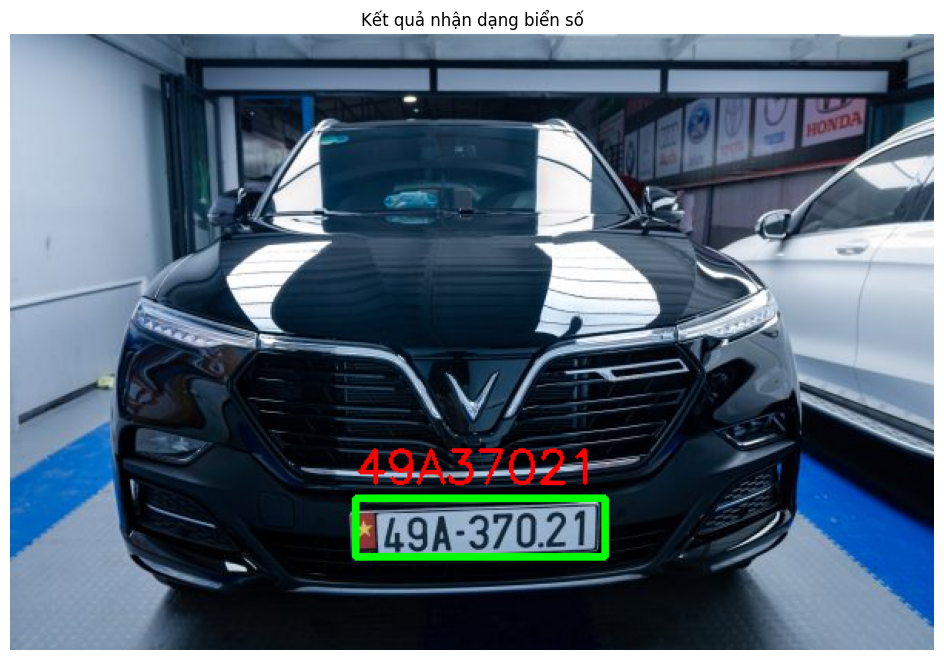

In [62]:
# Khởi tạo recognizer
recognizer = CustomLicensePlateRecognizer(plate_model, char_model)

# Test ảnh
image_path = "/kaggle/input/test12/test.jpg"
print(f"🖼️ Đang test với ảnh: {image_path}")
results = recognizer.recognize_from_path(image_path)

if results:
    for i, res in enumerate(results):
        print(f"\n📋 Biển số {i+1}:")
        print(f"📝 Text: {res['text']}")
        print(f"🎯 Confidence: {res['confidence']:.2f}")
    recognizer.visualize_results(image_path, results)
else:
    print("❌ Không nhận dạng được biển số nào.")

In [63]:
import cv2
import numpy as np
from ultralytics import YOLO
import os
import json
from datetime import datetime
import pandas as pd
import sys

class VideoLicensePlateRecognizer:
    def __init__(self, plate_model_path, char_model_path, output_dir="./output"):
        """
        Khởi tạo recognizer cho video
        
        Args:
            plate_model_path: Đường dẫn đến mô hình phát hiện biển số
            char_model_path: Đường dẫn đến mô hình nhận dạng ký tự
            output_dir: Thư mục lưu kết quả
        """
        try:
            self.plate_model = YOLO(plate_model_path)
            self.char_model = YOLO(char_model_path)
        except Exception as e:
            raise ValueError(f"Không thể tải model: {e}")
            
        self.output_dir = output_dir
        self.detected_plates = []  # Lưu trữ các biển số đã phát hiện
        
        # Tạo thư mục output
        os.makedirs(output_dir, exist_ok=True)
        
        # Kiểm tra môi trường GUI
        self.has_gui = self._check_gui_support()
        
    def _check_gui_support(self):
        """Kiểm tra xem môi trường có hỗ trợ GUI không"""
        try:
            # Thử tạo một window test
            test_img = np.zeros((100, 100, 3), dtype=np.uint8)
            cv2.imshow('test', test_img)
            cv2.waitKey(1)
            cv2.destroyWindow('test')
            return True
        except:
            return False
        
    def recognize_plate_in_frame(self, frame):
        """
        Nhận dạng biển số trong một frame
        
        Args:
            frame: Frame ảnh từ video
            
        Returns:
            List các biển số được phát hiện
        """
        results = []
        
        try:
            # Phát hiện biển số với verbose=False để giảm log
            plate_results = self.plate_model(frame, conf=0.5, verbose=False)
            
            for result in plate_results:
                if result.boxes is not None:
                    for box in result.boxes:
                        # Lấy tọa độ biển số
                        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
                        plate_conf = float(box.conf[0])
                        
                        # Kiểm tra tọa độ hợp lệ
                        if x2 <= x1 or y2 <= y1:
                            continue
                            
                        # Cắt vùng biển số với kiểm tra bounds
                        h, w = frame.shape[:2]
                        x1, y1 = max(0, x1), max(0, y1)
                        x2, y2 = min(w, x2), min(h, y2)
                        
                        plate_img = frame[y1:y2, x1:x2]
                        
                        if plate_img.size == 0:
                            continue
                        
                        # Nhận dạng ký tự trong biển số với verbose=False
                        char_results = self.char_model(plate_img, conf=0.3, verbose=False)
                        char_detections = []
                        
                        for char_result in char_results:
                            if char_result.boxes is not None:
                                for char_box in char_result.boxes:
                                    x_char = float(char_box.xyxy[0][0])
                                    class_id = int(char_box.cls[0])
                                    conf = float(char_box.conf[0])
                                    char = char_result.names[class_id]
                                    char_detections.append((x_char, char, conf))
                        
                        # Sắp xếp ký tự theo thứ tự từ trái sang phải
                        char_detections.sort(key=lambda x: x[0])
                        
                        # Ghép thành chuỗi biển số
                        text = ''.join([c for _, c, _ in char_detections])
                        avg_conf = sum([conf for _, _, conf in char_detections]) / len(char_detections) if char_detections else 0
                        
                        # Chỉ lấy biển số có độ tin cậy cao và có ít nhất 6 ký tự
                        if avg_conf > 0.5 and len(text) >= 6:
                            results.append({
                                'text': text,
                                'confidence': avg_conf,
                                'plate_conf': plate_conf,
                                'bbox': (x1, y1, x2, y2),
                                'plate_img': plate_img
                            })
        
        except Exception as e:
            print(f"⚠️ Lỗi khi nhận dạng frame: {e}")
        
        return results
    
    def draw_results_on_frame(self, frame, results, frame_number=0):
        """
        Vẽ kết quả lên frame
        
        Args:
            frame: Frame gốc
            results: Kết quả nhận dạng
            frame_number: Số thứ tự frame
            
        Returns:
            Frame đã được vẽ kết quả
        """
        annotated_frame = frame.copy()
        
        for result in results:
            x1, y1, x2, y2 = result['bbox']
            text = result['text']
            confidence = result['confidence']
            
            # Vẽ khung biển số
            cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0, 255, 0), 3)
            
            # Tạo background cho text
            label = f"{text} ({confidence:.2f})"
            (text_width, text_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)
            
            # Đảm bảo text không vượt ra ngoài frame
            text_y = max(y1 - 5, text_height + 5)
            cv2.rectangle(annotated_frame, (x1, text_y - text_height - 5), 
                         (x1 + text_width, text_y + 5), (0, 255, 0), -1)
            
            # Vẽ text
            cv2.putText(annotated_frame, label, (x1, text_y), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)
        
        # Thêm timestamp
        timestamp = f"Frame: {frame_number}"
        cv2.putText(annotated_frame, timestamp, (10, 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        
        return annotated_frame
    
    def process_video(self, input_video_path, output_video_path=None, save_plates=True, 
                     skip_frames=1, max_frames=None, show_progress=True):
        """
        Xử lý video để nhận dạng biển số
        
        Args:
            input_video_path: Đường dẫn video đầu vào
            output_video_path: Đường dẫn video đầu ra (nếu None sẽ tự tạo)
            save_plates: Có lưu ảnh biển số hay không
            skip_frames: Số frame bỏ qua để tăng tốc độ xử lý
            max_frames: Số frame tối đa để xử lý (None = xử lý hết)
            show_progress: Hiển thị tiến trình
            
        Returns:
            Dictionary chứa thống kê kết quả
        """
        # Mở video đầu vào
        cap = cv2.VideoCapture(input_video_path)
        if not cap.isOpened():
            raise ValueError(f"Không thể mở video: {input_video_path}")
        
        # Lấy thông tin video
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        if show_progress:
            print(f"📹 Thông tin video:")
            print(f"   - FPS: {fps}")
            print(f"   - Kích thước: {width}x{height}")
            print(f"   - Tổng frames: {total_frames}")
            print(f"   - GUI Support: {'Có' if self.has_gui else 'Không'}")
        
        # Tạo tên file output nếu không được cung cấp
        if output_video_path is None:
            base_name = os.path.splitext(os.path.basename(input_video_path))[0]
            output_video_path = os.path.join(self.output_dir, f"{base_name}_processed.mp4")
        
        # Khởi tạo video writer
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
        
        if not out.isOpened():
            raise ValueError(f"Không thể tạo video output: {output_video_path}")
        
        # Khởi tạo biến thống kê
        frame_count = 0
        processed_frames = 0
        unique_plates = set()
        all_detections = []
        
        # Tạo thư mục lưu ảnh biển số
        if save_plates:
            plates_dir = os.path.join(self.output_dir, "detected_plates")
            os.makedirs(plates_dir, exist_ok=True)
        
        if show_progress:
            print(f"🔄 Bắt đầu xử lý video...")
        
        try:
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                
                frame_count += 1
                
                # Bỏ qua frame nếu cần
                if frame_count % (skip_frames + 1) != 0:
                    out.write(frame)
                    continue
                
                # Giới hạn số frame xử lý
                if max_frames and processed_frames >= max_frames:
                    out.write(frame)
                    continue
                
                # Nhận dạng biển số
                results = self.recognize_plate_in_frame(frame)
                
                # Vẽ kết quả lên frame
                annotated_frame = self.draw_results_on_frame(frame, results, frame_count)
                
                # Lưu kết quả
                for i, result in enumerate(results):
                    plate_text = result['text']
                    timestamp = frame_count / fps if fps > 0 else 0
                    
                    # Thêm vào danh sách phát hiện
                    detection_info = {
                        'frame': frame_count,
                        'timestamp': timestamp,
                        'plate_text': plate_text,
                        'confidence': result['confidence'],
                        'plate_confidence': result['plate_conf'],
                        'bbox': result['bbox']
                    }
                    all_detections.append(detection_info)
                    
                    # Thêm vào set biển số unique
                    if result['confidence'] > 0.7:  # Chỉ lấy biển số có độ tin cậy cao
                        unique_plates.add(plate_text)
                    
                    # Lưu ảnh biển số
                    if save_plates and result['confidence'] > 0.6:
                        try:
                            plate_filename = f"plate_{frame_count}_{i}_{plate_text}.jpg"
                            # Loại bỏ ký tự đặc biệt trong tên file
                            plate_filename = "".join(c for c in plate_filename if c.isalnum() or c in "._-")
                            plate_path = os.path.join(plates_dir, plate_filename)
                            cv2.imwrite(plate_path, result['plate_img'])
                        except Exception as e:
                            print(f"⚠️ Không thể lưu ảnh biển số: {e}")
                
                # Ghi frame đã xử lý
                out.write(annotated_frame)
                processed_frames += 1
                
                # Hiển thị tiến trình
                if show_progress and frame_count % 100 == 0:
                    progress = (frame_count / total_frames) * 100
                    print(f"   Tiến trình: {progress:.1f}% ({frame_count}/{total_frames})")
        
        except KeyboardInterrupt:
            print("\n⚠️ Đã dừng xử lý theo yêu cầu người dùng")
        
        except Exception as e:
            print(f"❌ Lỗi trong quá trình xử lý: {e}")
        
        finally:
            # Giải phóng tài nguyên - FIX CHO LỖI GUI
            cap.release()
            out.release()
            
            # Chỉ gọi destroyAllWindows nếu có hỗ trợ GUI
            if self.has_gui:
                try:
                    cv2.destroyAllWindows()
                except:
                    pass  # Bỏ qua lỗi nếu không thể destroy windows
        
        # Lưu kết quả ra file
        self.save_detection_results(all_detections, unique_plates)
        
        # Thống kê kết quả
        stats = {
            'total_frames': total_frames,
            'processed_frames': processed_frames,
            'total_detections': len(all_detections),
            'unique_plates': len(unique_plates),
            'output_video': output_video_path,
            'unique_plates_list': list(unique_plates)
        }
        
        if show_progress:
            self.print_summary(stats)
        
        return stats
    
    def save_detection_results(self, all_detections, unique_plates):
        """
        Lưu kết quả nhận dạng ra file
        """
        try:
            # Lưu chi tiết tất cả các phát hiện
            detections_file = os.path.join(self.output_dir, "all_detections.json")
            with open(detections_file, 'w', encoding='utf-8') as f:
                json.dump(all_detections, f, ensure_ascii=False, indent=2)
            
            # Lưu danh sách biển số unique
            unique_plates_file = os.path.join(self.output_dir, "unique_plates.txt")
            with open(unique_plates_file, 'w', encoding='utf-8') as f:
                for plate in sorted(unique_plates):
                    f.write(f"{plate}\n")
            
            # Lưu thành CSV để dễ phân tích
            if all_detections:
                df = pd.DataFrame(all_detections)
                csv_file = os.path.join(self.output_dir, "detections.csv")
                df.to_csv(csv_file, index=False, encoding='utf-8')
                
        except Exception as e:
            print(f"⚠️ Lỗi khi lưu kết quả: {e}")
    
    def print_summary(self, stats):
        """
        In tóm tắt kết quả
        """
        print(f"\n{'='*50}")
        print(f"📊 TÓM TẮT KẾT QUẢ XỬ LÝ VIDEO")
        print(f"{'='*50}")
        print(f"🎬 Tổng số frames: {stats['total_frames']}")
        print(f"⚡ Frames đã xử lý: {stats['processed_frames']}")
        print(f"🔍 Tổng số lần phát hiện: {stats['total_detections']}")
        print(f"🚗 Số biển số unique: {stats['unique_plates']}")
        print(f"📁 Video đầu ra: {stats['output_video']}")
        
        if stats['unique_plates_list']:
            print(f"\n📋 DANH SÁCH BIỂN SỐ PHÁT HIỆN:")
            for i, plate in enumerate(sorted(stats['unique_plates_list']), 1):
                print(f"   {i:2d}. {plate}")
        
        print(f"\n📂 Kết quả đã được lưu tại: {self.output_dir}")
        print(f"{'='*50}")

# Hàm tiện ích để sử dụng
def process_video_with_license_plate_recognition(
    input_video_path,
    plate_model_path="/kaggle/working/saved_models/plate_detection_best.pt",
    char_model_path="/kaggle/working/saved_models/character_recognition_yolov8s_best.pt",
    output_dir="./video_output",
    skip_frames=2,  # Xử lý mỗi 3 frames để tăng tốc
    max_frames=None,
    show_progress=True
):
    """
    Hàm wrapper để xử lý video nhận dạng biển số
    
    Args:
        input_video_path: Đường dẫn video đầu vào
        plate_model_path: Đường dẫn mô hình phát hiện biển số
        char_model_path: Đường dẫn mô hình nhận dạng ký tự
        output_dir: Thư mục lưu kết quả
        skip_frames: Số frame bỏ qua (0 = xử lý tất cả)
        max_frames: Số frame tối đa xử lý (None = xử lý hết)
        show_progress: Hiển thị tiến trình
    
    Returns:
        Dictionary chứa thống kê kết quả
    """
    try:
        recognizer = VideoLicensePlateRecognizer(
            plate_model_path=plate_model_path,
            char_model_path=char_model_path,
            output_dir=output_dir
        )
        
        return recognizer.process_video(
            input_video_path=input_video_path,
            skip_frames=skip_frames,
            max_frames=max_frames,
            show_progress=show_progress
        )
        
    except Exception as e:
        print(f"❌ Lỗi khởi tạo recognizer: {e}")
        return None

# Ví dụ sử dụng
if __name__ == "__main__":
    # Xử lý video
    input_video = "/kaggle/input/test78/plate_video (1) (online-video-cutter.com).mp4"
    
    try:
        stats = process_video_with_license_plate_recognition(
            input_video_path=input_video,
            output_dir="./license_plate_output",
            skip_frames=1,  # Xử lý mỗi 2 frames
            max_frames=1000,  # Xử lý tối đa 1000 frames để test
            show_progress=True
        )
        
        if stats:
            print("✅ Xử lý video hoàn thành!")
        else:
            print("❌ Xử lý video thất bại!")
        
    except Exception as e:
        print(f"❌ Lỗi khi xử lý video: {e}")

📹 Thông tin video:
   - FPS: 30
   - Kích thước: 1280x720
   - Tổng frames: 179
   - GUI Support: Không
🔄 Bắt đầu xử lý video...
   Tiến trình: 55.9% (100/179)
⚠️ Lỗi khi lưu kết quả: Object of type int64 is not JSON serializable

📊 TÓM TẮT KẾT QUẢ XỬ LÝ VIDEO
🎬 Tổng số frames: 179
⚡ Frames đã xử lý: 89
🔍 Tổng số lần phát hiện: 89
🚗 Số biển số unique: 2
📁 Video đầu ra: ./license_plate_output/plate_video (1) (online-video-cutter.com)_processed.mp4

📋 DANH SÁCH BIỂN SỐ PHÁT HIỆN:
    1. 49A37021
    2. 88H8888

📂 Kết quả đã được lưu tại: ./license_plate_output
✅ Xử lý video hoàn thành!
